# The n-minute city


<mark>Warning: This notebook is memory-intensive</mark>
| Region | required RAM |
| --- | --- |
| Copenhagen | 10 GB |
| Denmark | 60 GB |

In [1]:
# imports
import gc
import graph_tool as gt
import graph_tool.topology
import graph_tool.search
import graph_tool.stats
import numpy as np
import pandas as pd
import geopandas as gpd
import gtfs_kit as gtfs
import shapely as shp
import pydeck as pdk
import datetime
import random
from tqdm import tqdm
import gc

import seaborn as sns


from lets_plot import *
LetsPlot.setup_html()

import matplotlib.pyplot as plt

from pyrosm import OSM, get_data

from numpy import uint64

/opt/conda/envs/graphs/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_31759/1033466117.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pyg

In [2]:
# H3-related helper functions
from h3ronpy.op import *
from h3ronpy import vector, util
import h3.api.numpy_int as h3 

H3_RES = 12
h3_set = set()

def coord_to_h3(lat, lon):
    h3_index = h3.geo_to_h3(lat, lon, H3_RES)
    h3_set.add(h3_index)
    return h3_index


# GTFS config
dates = ["20221007"]

## GTFS data processing
We are processing the rejseplanen GTFS file, which includes all public transit in Denmark

* add the H3 index to each stop using the `coord_to_h3` function + save encountered H3 indices in a set
* calculate headways for each route using the `compute_route_stats` function
* compute the list of stops for each route (this seems to be expensive and take quite a while)

In [3]:
# load GTFS data and convert stops to H3

gtfs_data = gtfs.feed.read_feed("../resources/rejseplanen", dist_units='m')
# add H3 information to stops
gtfs_data.stops['h3'] = gtfs_data.stops.apply(lambda row: coord_to_h3(row['stop_lat'], row['stop_lon']), axis=1)
print(f"added {len(h3_set)} h3 cells from GTFS data")

added 36094 h3 cells from GTFS data


In [4]:
gtfs_data = gtfs.create_shapes(gtfs_data, all_trips=True)

In [5]:
%%capture
# for each route and stop, calculate min, max and avg headways at each stop
# separate trips by mode (each mode will be a separate layer in the graph)
routes_geo = gtfs.routes.geometrize_routes(gtfs_data, split_directions=True)
trip_stats = gtfs.trips.compute_trip_stats(gtfs_data)
route_stats = gtfs.routes.compute_route_stats(gtfs_data, trip_stats, dates, split_directions=True, headway_start_time="05:00:00", headway_end_time="23:00:00")
route_stats = pd.merge(route_stats, routes_geo[["route_id", "direction_id", "geometry", "agency_id"]], on=["route_id", "direction_id"])


In [6]:
def geom_to_h3_list (geom: shp.geometry.LineString | shp.geometry.MultiLineString):
    if type(geom) == shp.geometry.LineString:
        return [coord_to_h3(lat, lon) for (lon, lat) in geom.coords]
    elif type(geom) == shp.geometry.MultiLineString:
        # flatten list of lists
        return [geom_to_h3_list(g) for g in geom]
    else:
        return []

In [7]:
route_stats['stop_list'] = route_stats['geometry'].apply(lambda row: geom_to_h3_list(row))

/tmp/ipykernel_464240/1436094751.py:6: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return [geom_to_h3_list(g) for g in geom]


sanitize route types a bit

In [8]:
def change_route_type(route_type: int) -> int:
    match route_type:
        case 109 | 1:
            # metro & stog
            return 1
        case 700 | 715 | 3:
            # bus
            return 3
        case 2:
            # train
            return 2
        case _:
            # other
            return 4

route_stats["route_type"] = route_stats["route_id"].apply(lambda row: change_route_type(gtfs_data.routes.loc[gtfs_data.routes['route_id'] == row]['route_type'].values[0]))

convert arrival and departure times to from strings to timestamps

In [9]:
time_format = "%H:%M:%S"

trip_selection = gtfs_data.get_trips(date=dates[0])
stop_time_selection = gtfs_data.get_stop_times(date=dates[0])
stop_time_selection['departure_time'] = pd.to_datetime(stop_time_selection['departure_time'], format=time_format, exact=False)
stop_time_selection['arrival_time'] = pd.to_datetime(stop_time_selection['arrival_time'], format=time_format, exact=False)
stop_time_selection = stop_time_selection.merge(gtfs_data.stops[["stop_id", "h3"]], on="stop_id")[["trip_id", "stop_id", "h3", "departure_time", "arrival_time", "stop_sequence"]]

print(stop_time_selection.columns)

Index(['trip_id', 'stop_id', 'h3', 'departure_time', 'arrival_time',
       'stop_sequence'],
      dtype='object')


get the distance between stops in minutes

In [10]:
# add stop_time information to trips
trip_selection_grouped = trip_selection.merge(stop_time_selection, on="trip_id", how="left").sort_values("trip_id").groupby("trip_id")

In [11]:
stop_dist_dict = {}

for trip_id, stop_times in tqdm(trip_selection_grouped):
    stop_times = stop_times.sort_values(by="stop_sequence", ascending=True)
    prev = None
    for six, stop in stop_times.iterrows():
        if prev is not None:
            sequence_id = (prev["h3"], stop["h3"])
            time_diffence = stop["arrival_time"] - prev["departure_time"]
            time_diffence = abs(time_diffence.total_seconds() / 60.0)
            if sequence_id in stop_dist_dict:
                if time_diffence < stop_dist_dict[sequence_id]:
                    stop_dist_dict[sequence_id] = time_diffence
            else:
                stop_dist_dict[sequence_id] = time_diffence

        prev = stop
    

100%|██████████| 45468/45468 [00:39<00:00, 1147.90it/s]


## OSM data processing
We are using pyrosm to process the OSM data for all of Denmark
* Due to ustom filters being broken in pyrosm, we are extracting all Ways and filter them manually using the pandas `query` function
* All ways are mapped to a list of H3 indices using the `vector.geodataframe_to_h3` from h3ronpy
* The set of unique H3 indicies is updated as well

In [12]:
# load OSM data using pyrosm
osm_cph = OSM("../resources/Copenhagen.osm.pbf")
osm = OSM("../resources/denmark-latest.osm.pbf")

# osm filters are currently broken
# osm_keys_to_keep = "highway"
# filter_type = "exclude"
# custom_filter = dict(
#     area=['yes'],
#     highway=["motor", "proposed", "construction", "abandoned", "platform", "raceway", "motorway", "motorway_link"],
#     walking=["no"],
#     service=["private"],
#     access=["private", "no"],
#     landuse=["military"]    
# )
# walk_net = osm_cph.get_data_by_custom_criteria(custom_filter, osm_keys_to_keep=osm_keys_to_keep, filter_type=filter_type, tags_as_columns=[])

In [13]:
# get all ways & filter later
# walk_net = osm.get_network("all")
base_net = osm_cph.get_network("all")

print(base_net.columns)

Index(['access', 'area', 'bicycle', 'bicycle_road', 'bridge', 'busway',
       'cycleway', 'foot', 'footway', 'highway', 'int_ref', 'junction',
       'lanes', 'lit', 'maxspeed', 'motorcar', 'motorroad', 'motor_vehicle',
       'name', 'oneway', 'overtaking', 'psv', 'ref', 'service', 'segregated',
       'sidewalk', 'smoothness', 'surface', 'tracktype', 'tunnel', 'turn',
       'width', 'id', 'timestamp', 'version', 'tags', 'osm_type', 'geometry',
       'length'],
      dtype='object')


In [14]:
base_net_reduced = base_net[['geometry', 'length', 'access', 'bicycle', 'bicycle_road', 'foot', 'footway', 'highway', 'cycleway']]

del base_net
gc.collect();

In [15]:
# perform manual filtering using pandas query function
walk_net_selection = base_net_reduced.query(' \
        access != "private" and access != "no" and \
        foot != "no" and foot != "private" and \
        highway != "motorway" and highway != "motorway_link" and highway != "prohibited" and \
        highway != "trunk" and highway != "trunk_link" and highway != "construction" \
    ')

bike_net_selection = base_net_reduced.query(' \
        access != "private" and access != "no" and \
        bicycle != "no" and bicycle != "private" and bicycle != "none" and \
        highway != "motorway" and highway != "motorway_link" and highway != "prohibited" and \
        highway != "trunk" and highway != "trunk_link" and highway != "construction" and \
        cycleway != "no" and  cycleway != "none" and cycleway != "shared" and \
        (cycleway == cycleway or bicycle_road == bicycle_road or bicycle == bicycle) \
    ')

In [142]:
# illustrate way to H3 conversion

# choose random way
way = walk_net_selection.sample(1).copy()[["geometry", "length"]]
way_h3s = vector.geodataframe_to_h3(way, h3_resolution=H3_RES)

# get polygons for each H3
way_h3s['geometry'] = way_h3s['h3index'].apply(lambda row: shp.geometry.Polygon(h3.h3_to_geo_boundary(row, geo_json=True)))
way_h3s = gpd.GeoDataFrame(way_h3s)

ggplot() + \
    geom_polygon(data=way_h3s) + \
    geom_path(data=way, color="red", size=2) + \
    coord_fixed(ratio=1) + \
    theme_classic()

In [16]:
print(f"paths in walk_network: {len(walk_net_selection)}")
print(f"paths in bike_network: {len(bike_net_selection)}")
h3s_walk = vector.geodataframe_to_h3(walk_net_selection, h3_resolution=H3_RES)
h3s_bike = vector.geodataframe_to_h3(bike_net_selection, h3_resolution=H3_RES)
print(f"number of h3 indices from walk_network: {len(h3s_walk)}")
print(f"number of h3 indices from bike_network: {len(h3s_bike)}")
h3s_walk = set(h3s_walk['h3index'])
h3s_bike = set(h3s_bike['h3index'])
print(f"number of unique h3 indices from walk_network: {len(h3s_walk)}")
print(f"number of unique h3 indices from bike_network: {len(h3s_bike)}")

# update set of H3 cells
h3_set.update(h3s_walk)

paths in walk_network: 117041
paths in bike_network: 14473
number of h3 indices from walk_network: 923569
number of h3 indices from bike_network: 172857
number of unique h3 indices from walk_network: 692354
number of unique h3 indices from bike_network: 152831


## Graph construction
We are using the `graph_tool` library to construct the graph
* The graph is directed and mulit-layered
* The main layer represents the walking network
* each mode of transit is then added as a separate layer

In [17]:
# create empty graph
g = gt.Graph(directed=True)

# setup edges
# each edge has the form source, target, weight, where source and target are strings consiting of the layer and the H3 index as hex string
edges = []

layer_colors = {
    0: [150, 79, 201, 79], # walk
    1: [158, 38, 21, 128],  # metro + s-tog
    2: [128, 124, 252, 99],# train
    3: [253, 235, 187, 99],# bus
    4: [201, 156, 79, 79], # other transit
    5: [255, 255, 255, 64],# bike
    9: [255, 255, 255, 128]# reserved (not used)
}

def create_node_index(h3_index: int, layer: int, route_id: str = "") -> str:
    return f"{layer}-{hex(h3_index)}-{route_id}"

* average hexagon diagonal length in meters: 20m
* average walk speed: 1.4 m/s
* average bike speed: 4.5 m/s
* time to walk across hexagon: 20m / 1.4m/s = 14s = 0.23 min
* time to bike across hexagon: 20m / 4.5m/s = 4.4s = 0.07 min

In [18]:
# walk network uses k-rings to connect to neighboring H3 cells
cell_walk_time = 0.23 # minutes
for h3_index in tqdm(h3_set):
    source_id = create_node_index(h3_index, 0)
    k_ring = h3.hex_ring(h3_index)
    for neighbor in k_ring:
        if neighbor in h3_set:
            target_id = create_node_index(neighbor, 0)
            edges.append([source_id, target_id, cell_walk_time])

print(f"nr of edges after adding walk network: {len(edges)}")

100%|██████████| 724855/724855 [00:05<00:00, 126782.82it/s]

nr of edges after adding walk network: 2201560


In [19]:
# add bike network
# works similar to walk network, but uses a different time & is connected to the walk network
cell_bike_time = 0.07 # minutes
for h3_index in tqdm(h3s_bike):
    k_ring = h3.hex_ring(h3_index)
    source_id = create_node_index(h3_index, 5)
    for neighbor in k_ring:
        if neighbor in h3s_bike:
            target_id = create_node_index(neighbor, 5)
            edges.append([source_id, target_id, cell_bike_time])
    # connection to walk network
    walk_id = create_node_index(h3_index, 0)

    edges.append([source_id, walk_id, 0.5])
    edges.append([walk_id, source_id, 1.0])


100%|██████████| 152831/152831 [00:01<00:00, 110957.19it/s]


In [20]:
# add transit network
# uses the stopsequence from GTFS and the average time between stops as the weight (for now)
# TODO: calculate the actual time between any two consecutive stops on a route
for idx, row in tqdm(route_stats.iterrows()):
    # stop_lists are sometimes nested, because of branching lines
    if len(row['stop_list']) == 0:
        continue
    if type(row['stop_list'][0]) != list:
        stop_list = [row['stop_list']]
    else:
        stop_list = row['stop_list']

    route_id = row['route_id']
    route_type = row['route_type']   
    
    for collection in stop_list:
        if len(collection) < 2:
            continue
        if row['direction_id'] == 1:
           collection = collection[::-1]
        nr_stops = len(collection)
        for i in range(nr_stops - 1):
            # add transit lines, adding the route_id to the node index effectively results in a unique layer for each line
            source_id = create_node_index(collection[i], route_type, route_id)
            target_id = create_node_index(collection[i+1], route_type, route_id)
            try:
                time = stop_dist_dict[(collection[i], collection[i+1])]
            except KeyError:
                try: 
                    time = stop_dist_dict[(collection[i+1], collection[i])]
                except KeyError:
                    time = 60.0
            edges.append([source_id, target_id, time])
        
        for stop in collection:
            # add connections between layers
            # ensure to not add duplicate connections
            source_id = create_node_index(stop, route_type, route_id)
            target_id = create_node_index(stop, 0)
            edges.append([target_id, source_id, row["mean_headway"] / 2.0]) # avg wait time is half the headway
            # TODO: decide time to leave stop based on route_type
            edges.append([source_id, target_id, 1.0]) # time to leave the stop & get back to the walk network is currently set at one minute



2606it [00:00, 4815.67it/s]


In [21]:
# add all edges
edge_weights = g.new_edge_property("double")
vertex_properties = g.add_edge_list(edges, eprops=[edge_weights], hashed=True)
print(f"number of vertices: {g.num_vertices()}, number of edges: {g.num_edges()}")

number of vertices: 943961, number of edges: 3414146


In [22]:
largest = gt.topology.extract_largest_component(g, directed=False)

parallel_edges = largest.new_edge_property("int")
gt.stats.label_parallel_edges(largest, mark_only=True, eprop=parallel_edges)
gt.stats.remove_parallel_edges(g)

print(f"number of parallel edges: {parallel_edges.fa.sum()} (removed)")

# remaining_h3s = list(map(lambda x: vertex_properties[x].split("-")[1], largest.vertices()))
print(f"number of vertices in largest component: {largest.num_vertices()}, number of edges in largest component: {largest.num_edges()}")

number of parallel edges: 0 (removed)
number of vertices in largest component: 941133, number of edges in largest component: 3097680


## Graph testing

In [23]:
def get_path(graph, weights, vprops, source, target):
    path = gt.topology.shortest_path(graph, source, target, weights)
    distance = gt.topology.shortest_distance(graph, source, target, weights)

    path_indices = []
    for v in path[0]:
        path_indices.append(vprops[v].split("-"))

    path_indices_df = gpd.GeoDataFrame(path_indices, columns=['layer','h3index', 'route_id'])
    path_indices_df['color'] = path_indices_df['layer'].apply(lambda x: layer_colors[int(x)])
    path_indices_df['geometry'] = path_indices_df['h3index'].apply(lambda x: shp.geometry.Point(h3.h3_to_geo(int(x, 16))[::-1]))
    path_indices_df['x'] = path_indices_df['geometry'].apply(lambda x: x.x)
    path_indices_df['y'] = path_indices_df['geometry'].apply(lambda x: x.y)

    return path_indices_df, distance


In [24]:
# get two random vertices
source = random.choice(list(largest.vertices()))
target = random.choice(list(largest.vertices()))
print(f"source: {vertex_properties[source]}, target: {vertex_properties[target]}")


path_indices_df, distance = get_path(largest, edge_weights, vertex_properties, source, target)
print(f"distance: {distance} minutes")
print("routes used: ", path_indices_df['route_id'].unique(), "modes of transit used: ", path_indices_df['layer'].unique())

view_state = pdk.ViewState(latitude=55.676098, longitude=12.568337, zoom=10)
plot = pdk.Deck(layers=[pdk.Layer("H3HexagonLayer", data=path_indices_df, get_hexagon="h3index", get_line_color="color", filled=True,
    extruded=False,line_width_min_pixels=10, get_fill_color="color", pickable=True
), pdk.Layer("PathLayer", data=path_indices_df)], initial_view_state=view_state)
plot.to_html("test_plot.html")

source: 5-0x8c1f059257669ff-, target: 0-0x8c1f236496a29ff-
distance: 54.899240506329136 minutes
routes used:  ['' '7418_700'] modes of transit used:  ['5' '0' '3']


In [25]:
ggplot() + \
    geom_livemap() + \
    geom_path(data=path_indices_df, mapping=aes(fill='color', x='x', y='y')) + \
    geom_point(data=path_indices_df, mapping=aes(x='x', y='y', color='layer'))
    

## Experiments

get all vertices within n minutes from the source

In [26]:
# max distance in minutes
max_dist = 60.0

In [27]:
# get some POIs
copenhagen_h = h3.geo_to_h3(55.67330421387207, 12.565949865641123, H3_RES)
itu = h3.geo_to_h3(55.66020636308543, 12.591662483469499, H3_RES)
søborg = h3.geo_to_h3(55.73587066279623, 12.51136446252421, H3_RES)

copenhagen_h_index = create_node_index(copenhagen_h, 0)
itu_index = create_node_index(itu, 0)
søborg_index = create_node_index(søborg, 0)

copenhagen_h_vertex = None
itu_vertex = None
søborg_vertex = None

# find vertex
for idx, v_prop in enumerate(vertex_properties):
    if v_prop == copenhagen_h_index:
        copenhagen_h_vertex = idx
    if v_prop == itu_index:
        itu_vertex = idx
    if v_prop == søborg_index:
        søborg_vertex = idx

print(f"copenhagen h index: {copenhagen_h_vertex}, itu index: {itu_vertex}, søborg index: {søborg_vertex}")

copenhagen h index: 380697, itu index: 21947, søborg index: 368317


In [28]:
source = copenhagen_h_vertex
print(f"source: {vertex_properties[source]}")

dist_map = largest.new_vertex_property("double")

dist_map, _ = gt.search.astar_search(largest, source=source, weight=edge_weights, visitor=gt.search.AStarVisitor(), infinity=max_dist*1.2, dist_map=dist_map)

source: 0-0x8c1f05833b60dff-


In [71]:
res_for_plot = []
for v in largest.vertices():
    distance = dist_map[v]
    [layer, index, route] = vertex_properties[v].split("-")
    if distance <= max_dist:
        res_for_plot.append([index, distance, layer])

res_for_plot_df = gpd.GeoDataFrame(res_for_plot, columns=['h3index', 'dist', 'layer'])
res_for_plot_df['geometry'] = res_for_plot_df['h3index'].apply(lambda x: shp.geometry.Point(h3.h3_to_geo(int(x, 16))[::-1]))
res_for_plot_df['hexagon_shape'] = res_for_plot_df[['h3index', 'layer']].apply(
    lambda x: shp.geometry.Polygon(h3.h3_to_geo_boundary(int(x[0], 16), geo_json=True)) if x[1] == '0' or x[1] == '5' else shp.geometry.Polygon(h3.h3_to_geo_boundary(h3.h3_to_parent(int(x[0], 16), 10), geo_json=True)), axis=1)
res_for_plot_df['color'] = res_for_plot_df['dist'].apply(lambda x: [int(255 * (1 - x / max_dist)), int(255 * (1 - x / max_dist)), x])
res_for_plot_df['x'] = res_for_plot_df['geometry'].apply(lambda x: x.x)
res_for_plot_df['y'] = res_for_plot_df['geometry'].apply(lambda x: x.y)

# view_state = pdk.ViewState(latitude=55.676098, longitude=12.568337, zoom=10)
# reach_plot = pdk.Deck(layers=[pdk.Layer("H3HexagonLayer", data=res_for_plot_df, get_hexagon="h3index", get_fill_color="color", get_line_color="color", filled=True,
#     extruded=False, line_width_min_pixels=1
# )], initial_view_state=view_state)
# reach_plot.to_html("test_plot.html")

Plot 1: Travel time from Københavns Hovedbanegård to all other points in the city

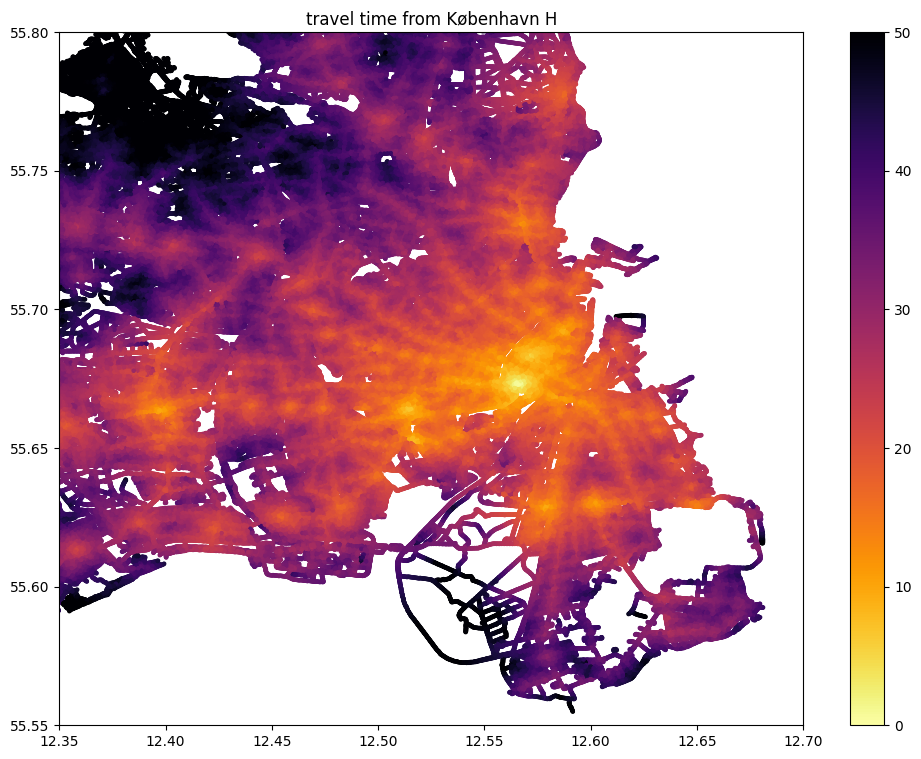

In [55]:
# scatter plot of points
scatter_df = res_for_plot_df[['x', 'y', 'dist', 'layer']].query("layer == '0'").sample(frac = 1)

fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.set_xlim(12.35, 12.7)
ax.set_ylim(55.55, 55.8)


ax.set_title("travel time from København H")
pts = ax.scatter(x=scatter_df['x'], y=scatter_df['y'], c=scatter_df['dist'], cmap="inferno_r", s=5, vmin=0, vmax=50)

plt.colorbar(pts)

In [31]:
# save df if neccessary
# scatter_df.reset_index().to_feather("scatter_df.feather")

In [72]:
layer_plot_order = {
    "0": 0,
    "1": 4,
    "2": 5,
    "3": 2,
    "4": 3,
    "5": 1,
}

In [73]:
res_for_plot_df['layer'] = res_for_plot_df['layer'].apply(lambda x: layer_plot_order[x])
lp_df = gpd.GeoDataFrame(res_for_plot_df[['dist','hexagon_shape', 'layer']].sort_values(by='layer', ascending=True))
lp_df.rename({'hexagon_shape': 'geometry'}, axis=1, inplace=True)

<AxesSubplot: title={'center': 'Multilayer H3 network for Copenhagen'}>

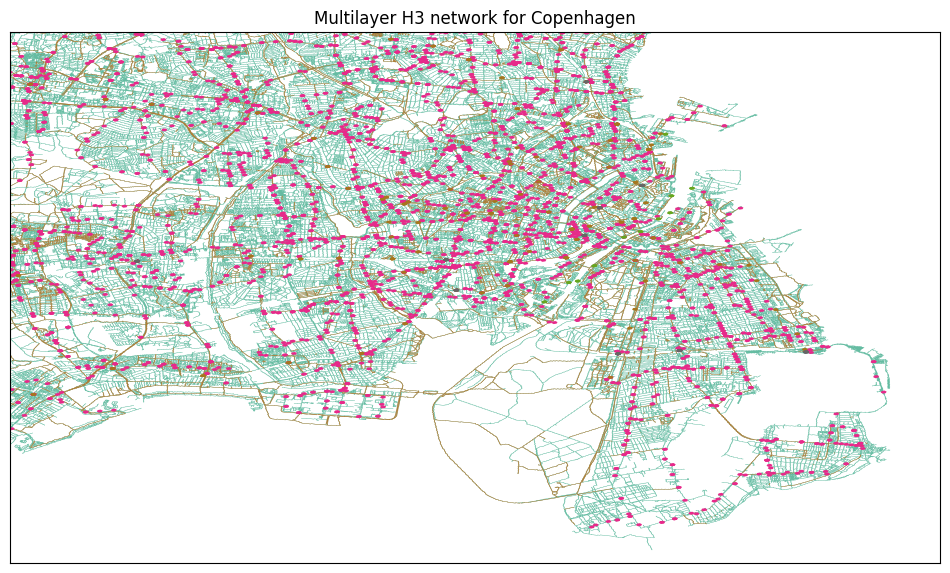

In [75]:
fig, ax = plt.subplots(1, 1,  figsize=(12,12))
ax.set_xlim(12.35, 12.70)
ax.set_ylim(55.55, 55.75)
ax.set_title("Multilayer H3 network for Copenhagen")
# ax.set_box_aspect(1)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

lp_df.plot(column='layer', cmap='Dark2', vmax=5, ax=ax, legend=False)

Plot 2: Travel time density from Københavns Hovedbanegård to all other points in the city, split by destination layer

<AxesSubplot: title={'center': 'Travel time from Copenhagen Central Station'}, xlabel='Travel time (minutes)', ylabel='Density'>

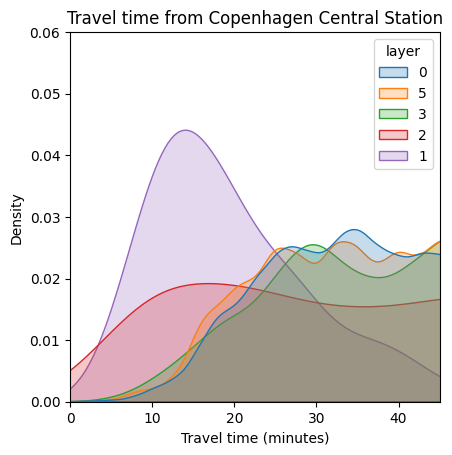

In [34]:
# kde plot for travel times, grouped by layer
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0, 45)
ax.set_ylim(0, 0.06)
ax.set_xlabel("Travel time (minutes)")
ax.set_title("Travel time from Copenhagen Central Station")
ax.set_box_aspect(1)
sns.kdeplot(data=lp_df.query("layer != '4'"), x='dist', hue='layer', ax=ax, legend=True, fill=True, common_norm=False)

Plot 3: Example routing

In [35]:
path_1, path_1_dist = get_path(largest, edge_weights, vertex_properties, søborg_vertex, itu_vertex)
path_2, path_2_dist = get_path(largest, edge_weights, vertex_properties, itu_vertex, copenhagen_h_vertex)

In [36]:
ggplot() + \
    geom_livemap() + \
    geom_path(data=path_1, mapping=aes(x='x', y='y'), label="Søborg -> ITU", color="red") + \
    geom_point(data=path_1, mapping=aes(x='x', y='y', color='layer'))
    # geom_path(data=path_2, mapping=aes(x='x', y='y'), label="ITU -> Copenhagen H", color="blue") + \
    # geom_point(data=path_2, mapping=aes(x='x', y='y', color='layer'))